<a href="https://colab.research.google.com/github/jeffersonaaron25/DeepLearning-FinalProject-JobPrediction/blob/main/notebooks/LSTMJobMatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prerequisite: Upload jobsdata_augmented_large.csv before running the notebook

In [10]:
import re
# word lemmatization
from nltk.stem import WordNetLemmatizer
# stopwords
from nltk.corpus import stopwords
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
import nltk

In [11]:
def clean_text(
    string: str, 
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=['the', 'a', 'and', 'is', 'be', 'will']) -> str: 
    """
    A method to clean text 
    """
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string

In [12]:
from tqdm import tqdm
jobs_data = pd.read_csv('jobsdata_augmented_large.csv')
for i in tqdm(range(len(jobs_data))):
  jobs_data['keywords'][i] = clean_text(jobs_data['keywords'][i])

100%|██████████| 82610/82610 [00:46<00:00, 1785.02it/s]


In [13]:
# one hot encoding using keras tokenizer and pad sequencing
X = jobs_data['keywords']
encoder = LabelEncoder()
y = encoder.fit_transform(jobs_data['job_title'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='')
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strings into integer lists
train_padseq = pad_sequences(train_seq, maxlen=300) # pads the integer lists to 2D integer tensor 

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=300)

word_index = tokenizer.word_index
max_words = 150000 # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 300 # max length of sequence 
y_train = to_categorical(y_train, num_classes=41)
y_test = to_categorical(y_test, num_classes=41)
print("Length of word index:", total_words)

shape of input data:  (82610,)
shape of target variable:  (82610,)
Length of word index: 4900


In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, SimpleRNN, LSTM, Dropout, Dense

model = Sequential()
model.add(Embedding(total_words+1, 70, input_length=maxlen))
model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(41, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 70)           343070    
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         69120     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 128)         24704     
 nal)                                                            
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 41)                1

In [15]:
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [16]:
# fit model to the data
history = model.fit(train_padseq, y_train,
batch_size=128,
epochs=25,
validation_split=0.2
)

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/25
414/414 [==============================] - 1112s 3s/step - loss: 2.4735 - accuracy: 0.2095 - val_loss: 2.1911 - val_accuracy: 0.2810
Epoch 2/25
414/414 [==============================] - 1089s 3s/step - loss: 1.9364 - accuracy: 0.3650 - val_loss: 1.8536 - val_accuracy: 0.3790
Epoch 3/25
414/414 [==============================] - 1083s 3s/step - loss: 1.6480 - accuracy: 0.4583 - val_loss: 1.5400 - val_accuracy: 0.4936
Epoch 4/25
414/414 [==============================] - 1083s 3s/step - loss: 1.3971 - accuracy: 0.5469 - val_loss: 1.4594 - val_accuracy: 0.5200
Epoch 5/25
414/414 [==============================] - 1084s 3s/step - loss: 1.2662 - accuracy: 0.5857 - val_loss: 1.2835 - val_accuracy: 0.5806
Epoch 6/25
414/414 [==============================] - 1080s 3s/step - loss: 1.1834 - accuracy: 0.6156 - val_loss: 1.2673 - val_accuracy: 0.5853
Epoch 7/25
414/414 [==============================] - 1081s 3s/step - loss: 1.1090 - accuracy: 0.6414 - val_loss: 1.2751 - val_accuracy:

In [17]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
    
epochs = range(1, len(train_loss) + 1)

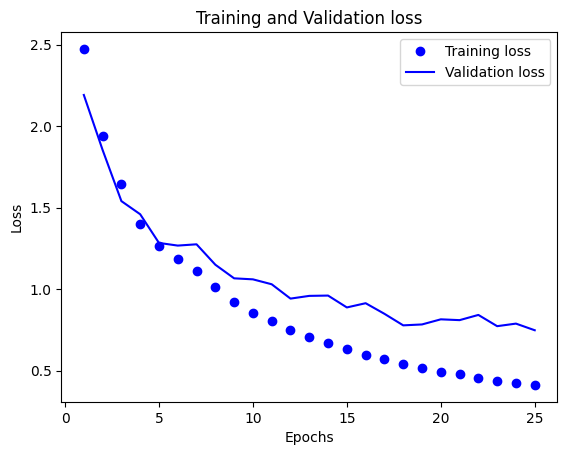

In [18]:
# Plot training loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

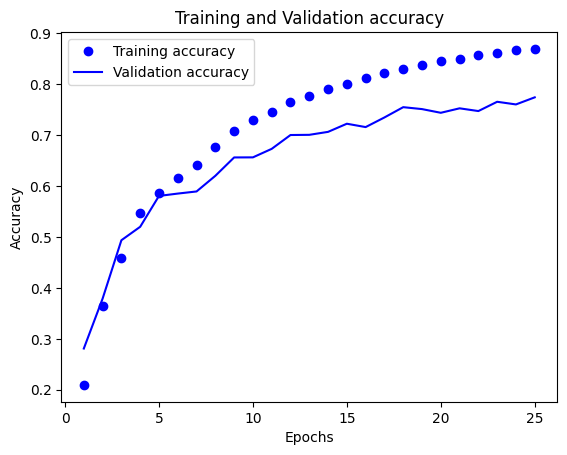

In [19]:
# Plot trainin accuracy 
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import numpy as np
def predict_job_title(model, tokenizer, input_keywords, maxlen, encoder):
    # Preprocess the input string
    input_keywords = input_keywords.lower()
    
    # Tokenize and pad the input string
    input_seq = tokenizer.texts_to_sequences([input_keywords])
    input_padseq = pad_sequences(input_seq, maxlen=maxlen)
    
    # Predict the job title
    prediction = model.predict(input_padseq)
    predicted_label = np.argmax(prediction, axis=-1)
    
    # Decode the predicted job title from the categorical representation
    job_title = encoder.inverse_transform(predicted_label)
    
    return job_title[0]

input_keywords = "javascript html css bootstrap python sql"
predicted_job_title = predict_job_title(model, tokenizer, input_keywords, maxlen, encoder)
print(f"Predicted job title: {predicted_job_title}")

1/1 [==============================] - 0s 80ms/step
Predicted job title: software engineer/developer
